Men hele dit prediction show er jo lidt hæmmet af at du kun har hert femte år.. Så må du agregere conflict... Det må du lige tænke lidt over...
-> Linear inapolationer er vil vejen frem. Lande rykker sig jo ikke lige pluslig selvom det kan virke såden?**

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import time

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from networkx.drawing.nx_agraph import graphviz_layout
import graphviz

from collections import Counter

In [3]:
df = pd.read_csv("diplodata_network_full.csv", index_col= 0)
df.reset_index(inplace = True, drop= True)

df.rename(columns= {'graph_deg_cantr_in.centralization' : 'graph_deg_cantr_in_centralization' , 
           'graph_deg_cantr_out.centralization' : 'graph_deg_cantr_out_centralization', 
           'graph_deg_cantr_all.centralization' : 'graph_deg_cantr_all_centralization'}, inplace = True)

In [30]:
cow = pd.read_csv("COW country codes.csv") # Just for lookups


In [4]:
df.head()
# du mangler node counts.

,country,year,indegree_norm,indegree,outdegree_norm,outdegree,degree_norm,degree,betweenness_dir,betweenness,...,graph_deg_cantr_all.res,graph_deg_cantr_all_centralization,graph_deg_cantr_all.theoretical_max,graph_betw_cantr_in.res,graph_betw_cantr_in.centralization,graph_betw_cantr_in.theoretical_max,graph_dens,Kcores_all,Kcores_in,Kcores_out
0,USA,1970,0.780303,103,0.719697,95,1.500000,198,1993.281177,955.851270,...,198,0.584079,34848,1993.281177,0.109892,2282544,0.208191,48,24,23
1,CAN,1970,0.454545,60,0.446970,59,0.901515,119,227.603410,98.964346,...,119,0.584079,34848,227.603410,0.109892,2282544,0.208191,48,24,23
2,CUB,1970,0.219697,29,0.204545,27,0.424242,56,31.492499,14.595786,...,56,0.584079,34848,31.492499,0.109892,2282544,0.208191,44,22,20
3,HAI,1970,0.000000,0,0.136364,18,0.136364,18,0.000000,0.478706,...,18,0.584079,34848,0.000000,0.109892,2282544,0.208191,18,0,16
4,DOM,1970,0.159091,21,0.159091,21,0.318182,42,6.359491,1.980701,...,42,0.584079,34848,6.359491,0.109892,2282544,0.208191,37,17,19


## Compare network statistics overtime: 

In [5]:
# du har ikke de rene tal med eks. degrees - burde du det?

df_year_stats = df.groupby('year').mean()[['indegree_norm','outdegree_norm','degree_norm','betweenness_dir_norm', 
                                           'betweenness_norm', 'graph_dens', 'graph_deg_cantr_in_centralization', 
                                           'graph_deg_cantr_out_centralization','graph_deg_cantr_all_centralization']]

df_year_stats.rename(columns = {'indegree_norm' : 'mean_indegree_norm',
                                'outdegree_norm' : 'mean_outdegree_norm',
                                'degree_norm' : 'mean_degree_norm',
                                'betweenness_norm' : 'mean_betweenness_norm',
                                'betweenness_dir_norm' : 'mean_betweenness_dir_norm'}, inplace = True)

df_year_stats

,mean_indegree_norm,mean_outdegree_norm,mean_degree_norm,mean_betweenness_dir_norm,mean_betweenness_norm,graph_dens,graph_deg_cantr_in_centralization,graph_deg_cantr_out_centralization,graph_deg_cantr_all_centralization
year,,,,,,,,,
1970,0.208191,0.208191,0.416382,0.006206,0.005804,0.208191,0.572112,0.609991,0.584079
1975,0.238088,0.238088,0.476176,0.005491,0.005249,0.238088,0.624231,0.631477,0.610507
1980,0.222623,0.222623,0.445245,0.005204,0.005009,0.222623,0.524131,0.602053,0.566748
1985,0.217275,0.217275,0.434550,0.004971,0.004800,0.217275,0.576475,0.601475,0.583223
1990,0.222298,0.222298,0.444596,0.005097,0.004729,0.222298,0.561653,0.604863,0.562014
1995,0.190271,0.190271,0.380542,0.004672,0.004310,0.190271,0.648439,0.621557,0.638412
2000,0.190271,0.190271,0.380542,0.004672,0.004310,0.190271,0.648439,0.621557,0.638412
2005,0.212179,0.212179,0.424357,0.004414,0.004128,0.212179,0.680294,0.631907,0.640710
2010,0.230326,0.230326,0.460652,0.004224,0.003900,0.230326,0.743219,0.616235,0.662048


# Relationship Between in- and out-degree:

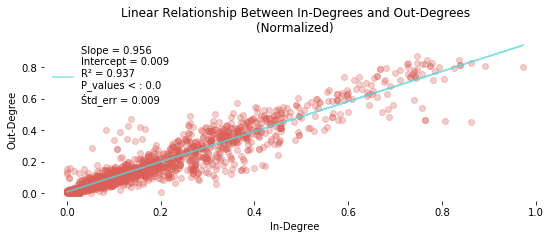

In [6]:
def plot_in_out(df=df):

    plt.figure(figsize=[9,3])
    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)

    plt.title('Linear Relationship Between In-Degrees and Out-Degrees\n(Normalized)')


    x = df['indegree_norm']
    y = df['outdegree_norm']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept


    label = 'Slope = ' + str(round(slope,3)) + \
        '\n' + 'Intercept = ' + str(round(intercept,3)) + \
        '\n' + 'R² = ' + str(round(r_value,3)) +\
        '\n' + 'P_values < : ' + str(round(p_value,3)) +\
        '\n' + 'Śtd_err = ' + str(round(std_err,3))

    plt.plot(x,y,'o', alpha = 0.3, label = '', color = colors[0])
    plt.plot(x, line, '-', label = label, alpha = 0.7, color = colors[1])

    plt.xlabel('In-Degree')
    plt.ylabel('Out-Degree')

    #plt.grid()
    sns.despine(left = True, bottom = True)
    plt.legend(frameon = False)
    plt.show()

    #print('slope: {:.3}\tintercept: {:.3}\tr²: {:.3}\tp_value: {:.3}\tstd_err: {:.3}'.format(slope, intercept, r_value**2, p_value, std_err))

plot_in_out()

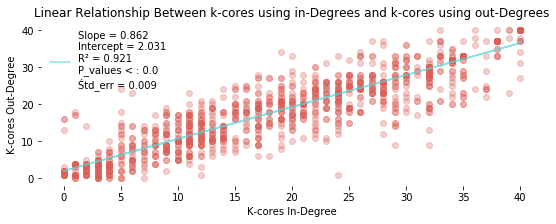

In [7]:
def plot_in_out_kcores(df=df):

    plt.figure(figsize=[9,3])
    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)

    plt.title('Linear Relationship Between k-cores using in-Degrees and k-cores using out-Degrees')


    x = df['Kcores_in']
    y = df['Kcores_out']

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept


    label = 'Slope = ' + str(round(slope,3)) + \
        '\n' + 'Intercept = ' + str(round(intercept,3)) + \
        '\n' + 'R² = ' + str(round(r_value,3)) +\
        '\n' + 'P_values < : ' + str(round(p_value,3)) +\
        '\n' + 'Śtd_err = ' + str(round(std_err,3))

    plt.plot(x,y,'o', alpha = 0.3, label = '', color = colors[0])
    plt.plot(x, line, '-', label = label, alpha = 0.7, color = colors[1])

    plt.xlabel('K-cores In-Degree')
    plt.ylabel('K-cores Out-Degree')

    #plt.grid()
    sns.despine(left = True, bottom = True)
    plt.legend(frameon = False)
    plt.show()

    #print('slope: {:.3}\tintercept: {:.3}\tr²: {:.3}\tp_value: {:.3}\tstd_err: {:.3}'.format(slope, intercept, r_value**2, p_value, std_err))

plot_in_out_kcores()

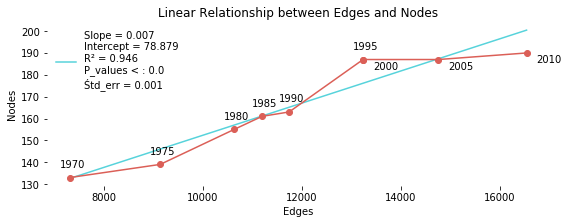

slope: 0.00735	intercept: 78.9	r²: 0.896	p_value: 0.000111	std_err: 0.000947


In [8]:
def lin_plot_e_n():

    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)
    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    labels = ['{}'.format(str(i)) for i in years]


    plt.figure(figsize=[9,3])

    x = np.array(df.groupby('year').sum()['degree']) # edges

    y = np.array(df.groupby('year').count()['country']) # nodes

    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    
    
    label = 'Slope = ' + str(round(slope,3)) + \
    '\n' + 'Intercept = ' + str(round(intercept,3)) + \
    '\n' + 'R² = ' + str(round(r_value,3)) +\
    '\n' + 'P_values < : ' + str(round(p_value,3)) +\
    '\n' + 'Śtd_err = ' + str(round(std_err,3))
    
    plt.plot(x, line, '-', alpha = 1, color = colors[1], label = label)
    plt.plot(x,y,'-o', alpha = 1, color = colors[0])

    
    #labels = years
    for label, x, y in zip(labels, x, y):
        if label in np.array(years[0:6]).astype('str'): # if statement to offset annotations and not clutter 1995 and 2000
            plt.annotate(label, xy=(x, y), xytext=(-10, 10), textcoords='offset points' ) #, ha='right', va='bottom')
            
        else:
            plt.annotate(label, xy=(x, y), xytext=(10, -10), textcoords='offset points' ) #, ha='right', va='bottom')

    
    
    plt.xlabel('Edges')
    plt.ylabel('Nodes')
    
    plt.title('Linear Relationship between Edges and Nodes')
    
    #plt.grid()
    sns.despine(left = True, bottom = True)

    plt.legend(frameon = False)

    plt.savefig('lin_edge_node.pdf', bbox_inches="tight")

    plt.show()
    print('slope: {:.3}\tintercept: {:.3}\tr²: {:.3}\tp_value: {:.3}\tstd_err: {:.3}'.format(slope, intercept, r_value**2, p_value, std_err))
    
lin_plot_e_n()

# men der sker jo faktisk lidt til sidst. Det kan man også se på det tidligere plot. Ikke flere nodes. men flere edges.

# Degree Dist over time:

In [9]:
def degree_dist_plot(norm = True, kind = 'undirected', kde = True):
    
    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    colors = sns.palettes.color_palette(palette = "hls", n_colors = len(years))

    plt.figure(figsize=(9,3))

    for i in range(len(years)):
        
        year_subset = df[df['year']==years[i]]
        color = colors[i]
    
    
        if kind == 'undirected':
        
            x = year_subset['degree_norm']
            title = 'Degree Distribution'
            xlabel = 'Normalized Degrees'
        
        elif kind == 'in':
            
            x = year_subset['indegree_norm']
            title = 'In-Degree Distribution'
            xlabel = 'Normalized In-Degrees'


        
        elif kind == 'out':

            x = year_subset['outdegree_norm']
            title = 'Out-Degrees Distribution'
            xlabel = 'Normalized Out-Degrees'


        
        else:
            print('unkown "kind" specification')

        
        if kde == True:
            sns.kdeplot(x, alpha = 0.6, label = str(years[i]),  color = color)
            
            title = title + '\n(KDE)'
        
        else:
            plt.hist(x, alpha = 0.6, label = str(years[i]),  color = color, histtype = 'step')
            
            title = title + '\n(Histogram)'


        
        plt.title(title)        

        maximum = max(x)
        minimum = 0  #np.min(count[0])

        plt.xlim(minimum,maximum) #burde automatiseres
        plt.xlabel(xlabel)
        plt.title(title)

        #plt.ylim(0,maximum*1.1)
        plt.yticks([])

        #plt.grid()
        sns.despine(left = True)
        plt.legend(frameon = False)

    plt.show()
                                

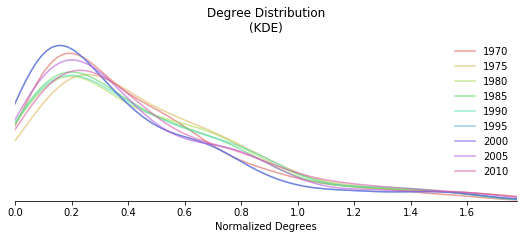

In [10]:
degree_dist_plot()

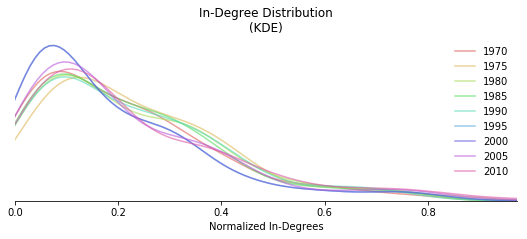

In [11]:
degree_dist_plot(kind = 'in')

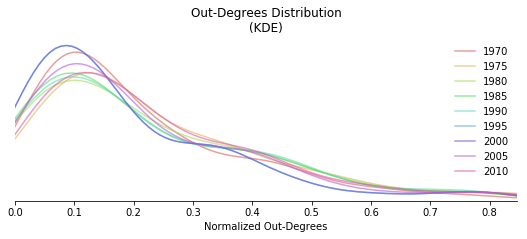

In [12]:
degree_dist_plot(kind = 'out')

# Time trends:

In [13]:
centralization = ['graph_deg_cantr_in_centralization','graph_deg_cantr_out_centralization','graph_deg_cantr_all_centralization']

def time_plot(df = df_year_stats, feature_list = centralization, y_label = '', title = ''):

    plt.figure(figsize= [9,3])

    #feature_list = centralization
    colors = sns.palettes.color_palette(palette = "hls", n_colors = len(feature_list))


    for i in range(len(feature_list)):

            x = df_year_stats[feature_list[i]].index
            y = df_year_stats[feature_list[i]]

            label = feature_list[i]

            plt.plot(x,y,'-o', label = label, alpha = 0.6, color = colors[i])

    plt.xlabel('Year')
    plt.ylabel(y_label)#right

    plt.title(title)

    #plt.ylim(-1.6,5)

    sns.despine(left = True, bottom = True)
    #plt.grid()
    plt.legend(frameon = False)
    plt.show()  
    


# Time Plots - means, density and centralization
### For all time plots insert math + written intuitiuon and how to interpreate the matrix given the subject at hand:

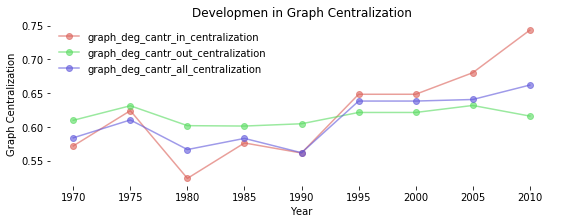

In [14]:
time_plot(y_label='Graph Centralization', title = 'Developmen in Graph Centralization')

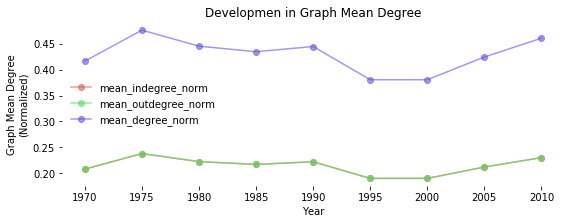

Indegree = Outdegree


In [15]:
mean_degree = ['mean_indegree_norm', 'mean_outdegree_norm', 'mean_degree_norm']
time_plot(feature_list = mean_degree, y_label='Graph Mean Degree\n(Normalized)', title = 'Developmen in Graph Mean Degree')
print('Indegree = Outdegree')

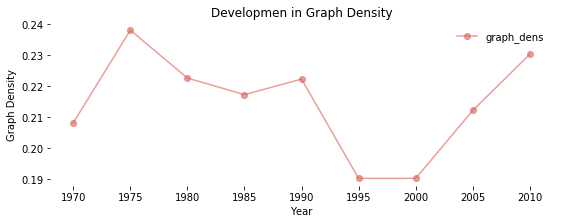

In [16]:
mean_degree = ['graph_dens']
time_plot(feature_list = mean_degree, y_label='Graph Density', title = 'Developmen in Graph Density')
print('')

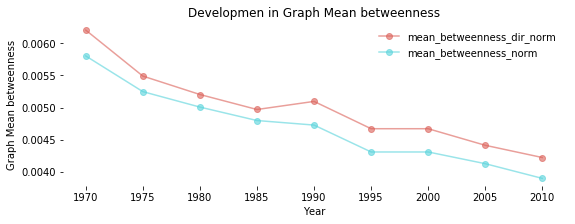

In [17]:
mean_betweenness = ['mean_betweenness_dir_norm','mean_betweenness_norm']
time_plot(feature_list = mean_betweenness, y_label='Graph Mean betweenness', title = 'Developmen in Graph Mean betweenness')
print('')

# Centrality scatter: the power players

In [18]:
def list_power_players(year = 2010, metric = 'betweenness_dir_norm',y = 'outdegree_norm'):

    metric_set = df[df['year'] == year].sort_values(metric, ascending = False).head(10)['country'].reset_index(drop=True)

    return(metric_set)




In [19]:
list_power_players(metric = 'betweenness_dir_norm')

0    USA
1    CHN
2    UKG
3    FRN
4    JPN
5    GMY
6    RUS
7    BEL
8    IND
9    BRA
Name: country, dtype: object

In [20]:
list_power_players(metric='outdegree_norm')

0    CHN
1    FRN
2    USA
3    GMY
4    RUS
5    UKG
6    JPN
7    EGY
8    ITA
9    CUB
Name: country, dtype: object

In [21]:
list_power_players(metric='indegree_norm')

0    USA
1    BEL
2    CHN
3    UKG
4    FRN
5    IND
6    GMY
7    RUS
8    CAN
9    JPN
Name: country, dtype: object

In [22]:
def plot_power_players(year = 2010, x = 'indegree_norm',y = 'outdegree_norm', z='betweenness_dir_norm', scale = 1200, measure = 'powerfull', fig_title = 'power_players.pdf'):
    
    """Power understood as power projected, that implies out-degrees"""
    
    degree_set = set(df[df['year'] == year].sort_values(y, ascending = False).head(10)['country'])
    between_set = set(df[df['year'] == year].sort_values(x, ascending = False).head(10)['country'])

    power_set  = set.intersection(degree_set, between_set)

    power_df = df[df['country'].isin(power_set)]
    
    # Simple Scatter
    plt.figure(figsize=[9,5])
    
    x_obs = df[x]
    y_obs = df[y]
    z_obs = df[z] * scale # 1200 just to scale
    
    plt.scatter(x_obs, y_obs, z_obs, alpha = 0.5, label = '', color = 'grey')
    
    
    # Power_Players:
    colors = sns.palettes.color_palette(palette = "hls", n_colors = len(power_set))
    
    for i in range(len(power_set)):
        
            x_sub = power_df[power_df['country']==list(power_set)[i]].sort_values('year')[x]
            y_sub = power_df[power_df['country']==list(power_set)[i]].sort_values('year')[y]
            
            label = list(power_set)[i]
        
            plt.plot(x_sub,y_sub, '-o', label = label, color=colors[i], alpha = 0.9)#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])
    
    
    # Start and end_point for power_players:
    
    for i in range(len(power_set)):
        
            start_year = power_df[power_df['country']==list(power_set)[i]]['year'].min()
            end_year =  power_df[power_df['country']==list(power_set)[i]]['year'].max()
        
            x_start = power_df[(power_df['country']==list(power_set)[i]) & (power_df['year'] == start_year)][x]
            y_start = power_df[(power_df['country']==list(power_set)[i]) & (power_df['year'] == start_year)][y]
            
            x_end = power_df[(power_df['country']==list(power_set)[i]) & (power_df['year'] == end_year)][x]
            y_end = power_df[(power_df['country']==list(power_set)[i]) & (power_df['year'] == end_year)][y]
                    
            plt.scatter(x_start,y_start, marker = 'x', label = '', color=colors[i], s = 300)#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])
            plt.scatter(x_end,y_end, marker = '^', label = '', color=colors[i], s = 200)#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])

    

    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.text(0.4,0.2,"Scatter size reflects {}".format(z))
    
    plt.ylim(0,1)
    
    plt.title('Relationship between {}, {} and {}\n(all years - most "{}" in {} colored)'.format(x,y,z,measure,str(year)))
    
    #plt.grid()
    sns.despine(left = True, bottom = True)

    plt.legend(frameon = False)
    
    fig_title = 'power_players.pdf'
    plt.savefig(fig_title, bbox_inches="tight")
    
    
    plt.show()

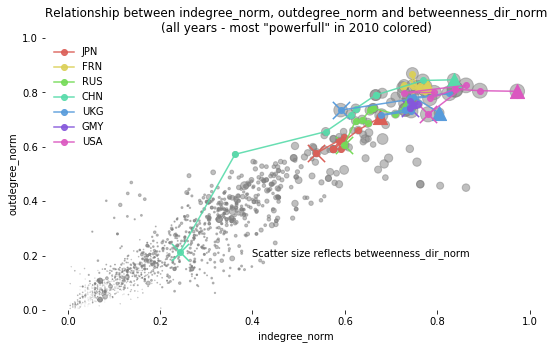

In [23]:
plot_power_players(scale=2000)

## Weak players

In [26]:
def list_weak_players(year = 2010, metric = 'betweenness_dir_norm',y = 'outdegree_norm'):

    metric_set = df[df['year'] == year].sort_values(metric, ascending = True).head(10)['country'].reset_index(drop=True)

    return(metric_set)


In [34]:
cow[cow['StateAbb'].isin(list_weak_players(metric = 'betweenness_dir_norm'))]

,StateAbb,CCode,StateNme
12,DMA,54,Dominica
13,GRN,55,Grenada
16,AAB,58,Antigua & Barbuda
119,ICE,395,Iceland
166,COM,581,Comoros
168,SEY,591,Seychelles
211,BHU,760,Bhutan
216,MAD,781,Maldives
235,TUV,947,Tuvalu
241,FSM,987,Federated States of Micronesia


In [35]:
cow[cow['StateAbb'].isin(list_weak_players(metric = 'outdegree_norm'))]

,StateAbb,CCode,StateNme
15,SVG,57,St. Vincent and the Grenadines
16,AAB,58,Antigua & Barbuda
232,VAN,935,Vanuatu
234,KIR,946,Kiribati
235,TUV,947,Tuvalu
237,TON,955,Tonga
238,NAU,970,Nauru
239,MSI,983,Marshall Islands
240,PAL,986,Palau
241,FSM,987,Federated States of Micronesia


In [36]:
cow[cow['StateAbb'].isin(list_weak_players(metric = 'indegree_norm'))]

,StateAbb,CCode,StateNme
12,DMA,54,Dominica
164,SWA,572,Swaziland
166,COM,581,Comoros
211,BHU,760,Bhutan
232,VAN,935,Vanuatu
234,KIR,946,Kiribati
235,TUV,947,Tuvalu
238,NAU,970,Nauru
239,MSI,983,Marshall Islands
242,WSM,990,Samoa


In [24]:
def plot_weak_players(year = 2010, x = 'indegree_norm',y = 'outdegree_norm', z='betweenness_dir_norm', scale = 1200, measure = 'powerfull', fig_title = 'power_players.pdf'):
    
    """Power understood as power projected, that implies out-degrees"""
    
    degree_set = set(df[df['year'] == year].sort_values(y, ascending = True).head(10)['country'])
    between_set = set(df[df['year'] == year].sort_values(x, ascending = True).head(10)['country'])

    power_set  = set.intersection(degree_set, between_set)

    power_df = df[df['country'].isin(power_set)]
    
    # Simple Scatter
    plt.figure(figsize=[9,5])
    
    x_obs = df[x]
    y_obs = df[y]
    z_obs = df[z] * scale # 1200 just to scale
    
    plt.scatter(x_obs, y_obs, z_obs, alpha = 0.5, label = '', color = 'grey')
    
    
    # Power_Players:
    colors = sns.palettes.color_palette(palette = "hls", n_colors = len(power_set))
    
    for i in range(len(power_set)):
        
            x_sub = power_df[power_df['country']==list(power_set)[i]].sort_values('year')[x]
            y_sub = power_df[power_df['country']==list(power_set)[i]].sort_values('year')[y]
            
            label = list(power_set)[i]
        
            plt.plot(x_sub,y_sub, '-o', label = label, color=colors[i], alpha = 0.9)#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])
    
    
    # Start and end_point for power_players:
    
    for i in range(len(power_set)):
        
            start_year = power_df[power_df['country']==list(power_set)[i]]['year'].min()
            end_year =  power_df[power_df['country']==list(power_set)[i]]['year'].max()
        
            x_start = power_df[(power_df['country']==list(power_set)[i]) & (power_df['year'] == start_year)][x]
            y_start = power_df[(power_df['country']==list(power_set)[i]) & (power_df['year'] == start_year)][y]
            
            x_end = power_df[(power_df['country']==list(power_set)[i]) & (power_df['year'] == end_year)][x]
            y_end = power_df[(power_df['country']==list(power_set)[i]) & (power_df['year'] == end_year)][y]
                    
            plt.scatter(x_start,y_start, marker = 'x', label = '', color=colors[i], s = 300)#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])
            plt.scatter(x_end,y_end, marker = '^', label = '', color=colors[i], s = 200)#,  s=200+j*100, facecolors='none', edgecolors=my_colors2[j], label = labels2[j])

    

    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.text(0.4,0.2,"Scatter size reflects {}".format(z))
    
    plt.ylim(0,1)
    
    plt.title('Relationship between {}, {} and {}\n(all years - most "{}" in {} colored)'.format(x,y,z,measure,str(year)))
    
    #plt.grid()
    sns.despine(left = True, bottom = True)

    plt.legend(frameon = False)
    
    fig_title = 'power_players.pdf'
    plt.savefig(fig_title, bbox_inches="tight")
    
    
    plt.show()

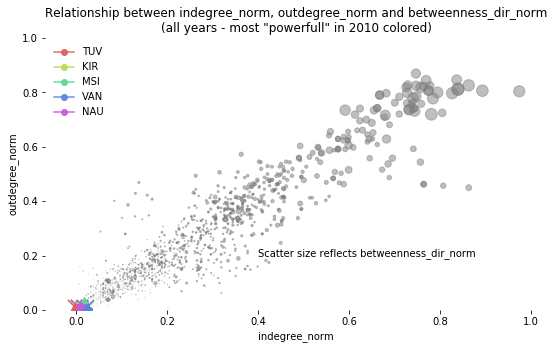

In [25]:
plot_weak_players()

** Men hvilken mål er bedst til conflict prediction (onset)? Og hvilke mål passer teoritisk bedst?**

Men der er flere ting her. 
- Målene her over er simplet 'state strenght-ish'
- Perifiry/center er vel noget lidt andet? (og igen burde periferien dis-aggregeres?)
- Og hvad med ind/out ratio

I sidste ende hanlder det jo også om hvad dine edges symbolicere!


# Time plot - k-cores
men det het skal være anderledes... Noget med om man rykke fra en core ud if en mere perifer core-specification...

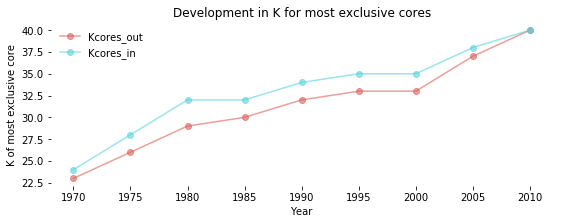

In [37]:
def get_k_size(df = df, metric1 = 'Kcores_out', metric2 = 'Kcores_in'):

    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    colors = sns.palettes.color_palette(palette = "hls", n_colors=2)

    kcores_size_list1 = []
    kcores_size_list2 = []


    for i in range(len(years)):

        kcores_size1 = df[df['year'] == years[i]][metric1].max()
        kcores_size_list1.append(kcores_size1)

        kcores_size2 = df[df['year'] == years[i]][metric2].max()
        kcores_size_list2.append(kcores_size2)
        
    plt.figure(figsize= [9,3])

    x = years
    y1 = kcores_size_list1
    y2 = kcores_size_list2


    plt.plot(x,y1,'-o', alpha = 0.6, color = colors[0], label = metric1)
    plt.plot(x,y2,'-o', alpha = 0.6, color = colors[1], label = metric2)


    plt.xlabel('Year')
    plt.ylabel("K of most exclusive core")#right

    plt.title('Development in K for most exclusive cores')

    sns.despine(left = True, bottom = True)
    #plt.grid()
    plt.legend(frameon = False)
    
    fig_title = 'devl_Kcores.pdf'
    plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()
    
get_k_size()


This make sens since the network has become bigger and also more inter connected.

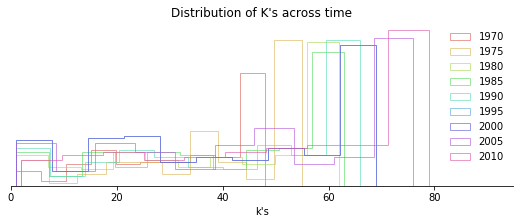

In [38]:
def k_core_hist(df=df, metric = 'Kcores_all'):

    plt.figure(figsize=[9,3])
    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    colors = sns.palettes.color_palette(palette = "hls", n_colors = len(years))

    for i in range(len(years)):

        year_subset = df[df['year']==years[i]]
        color = colors[i]

        x = year_subset[metric]

        #sns.kdeplot(x, alpha = 0.6, label = str(years[i]),  color = color)
        plt.hist(x, alpha = 0.6, label = str(years[i]),  color = color, histtype='step')


    plt.title("Distribution of K's across time")        

    maximum = max(x) * 1.2
    minimum = 0  #np.min(count[0])

    plt.xlim(minimum,maximum) #burde automatiseres
    plt.xlabel("k's")

            #plt.ylim(0,maximum*1.1)
    plt.yticks([])

            #plt.grid()
    sns.despine(left = True)
    plt.legend(frameon = False)


    plt.show()
    
k_core_hist()

Men det er vel egenligt en fin nok featuer i sig selv...

In [47]:
def norm_k_cores(df=df, metric = 'Kcores_all'):
    
    new_metric_name = metric + '_norm'
    
    k_max = df.groupby('year')[metric].transform(np.max)
    df[new_metric_name] = df[metric]/k_max

norm_k_cores()
norm_k_cores(metric = 'Kcores_in')
norm_k_cores(metric = 'Kcores_out')

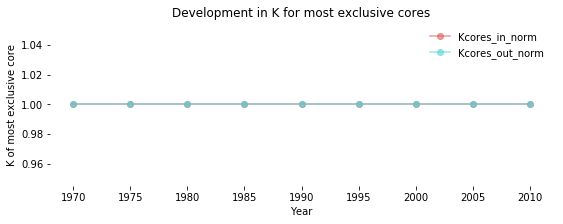

In [48]:
get_k_size(metric1= 'Kcores_in_norm', metric2= 'Kcores_out_norm')

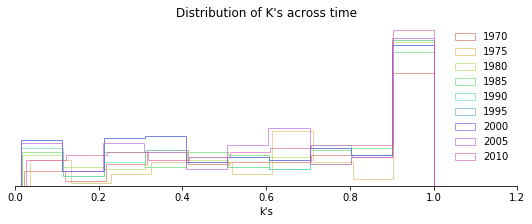

In [27]:
k_core_hist(metric='Kcores_all_norm')

### The binary center/perifery

In [49]:
def make_center_feature(df=df, metric = 'Kcores_all'):

    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    new_feature_name = metric + '_center'
    
    df[new_feature_name] = 0

    for i in range(len(years)):
        
        center = max(Counter(df[df['year'] == years[i]][metric]))
        df.loc[(df['year'] == years[i]) & (df[metric] == center), new_feature_name] = 1
        
make_center_feature(metric = 'Kcores_all')
make_center_feature(metric = 'Kcores_in')
make_center_feature(metric = 'Kcores_out')

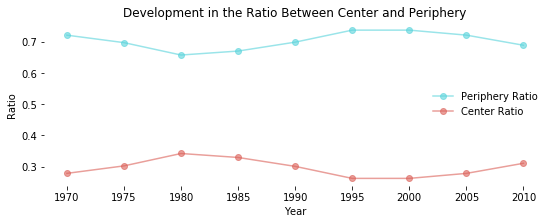

In [50]:
def center_ratio_plot(df=df):

    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    
    center_list = []
    center_ratio_list = []
    periphery_list = []
    
    for i in range(len(years)):
        
        size_of_center = df[(df['year'] == years[i]) & (df['Kcores_all_center'] == 1)].shape[0]

        center_ratio = size_of_center / df[df['year'] == years[i]].shape[0]
        
        periphery_ratio = 1 - center_ratio

        center_list.append(size_of_center)
        center_ratio_list.append(center_ratio)
        periphery_list.append(periphery_ratio)
    
    # Ratio plot
    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)

    plt.figure(figsize= [9,3])

    label1 = 'Center Ratio'
    label2 = 'Periphery Ratio'
    
    x = years
    y1 = center_ratio_list
    y2 = periphery_list

    plt.plot(x, y2, '-o', alpha = 0.6, color = colors[1], label = label2)
    plt.plot(x,y1,'-o',alpha = 0.6, color = colors[0], label = label1)
    
    plt.xlabel('Year')
    plt.ylabel("Ratio")#right

    plt.title('Development in the Ratio Between Center and Periphery')

    sns.despine(left = True, bottom = True)
    #plt.grid()
    plt.legend(frameon = False) 
    
    fig_title = 'center_periphery_ratio.pdf'
    plt.savefig(fig_title, bbox_inches="tight")

    
    plt.show() 
        
center_ratio_plot()

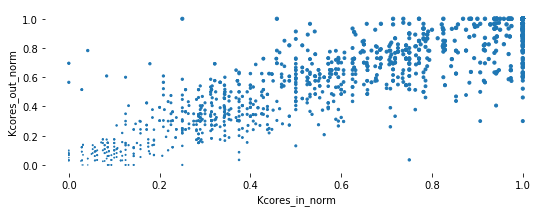

In [70]:
plt.figure(figsize=[9,3])

x = df['Kcores_in_norm']
y = df['Kcores_out_norm']
z = df['Kcores_all_norm'] * 12


plt.scatter(x,y,z)

plt.xlabel('Kcores_in_norm')
plt.ylabel('Kcores_out_norm')

sns.despine(left = True, bottom = True)
plt.show()

## Asseseing the core metrics

In [ ]:
Kcores_all_center

Kcores_in_center

Kcores_out_center

In [75]:
df[(df['year']==2010) & (df['Kcores_in_center'] == 1) ][['Kcores_in_center','country']]

,Kcores_in_center,country
1312,1,USA
1313,1,CAN
1315,1,CUB
1327,1,MEX
1341,1,BRA
1344,1,CHL
1345,1,ARG
1347,1,UKG
1348,1,IRE
1349,1,NTH


# UNDER CONSTRUCTION:

In [19]:
def make_center_feature(df=df):

    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    df['center'] = 0

    for i in range(len(years)):
        
        center = max(Counter(df[df['year'] == years[i]]['Kcores_all']))
        df.loc[(df['year'] == years[i]) & (df['Kcores_all'] == center), 'center'] = 1
        
make_center_feature()

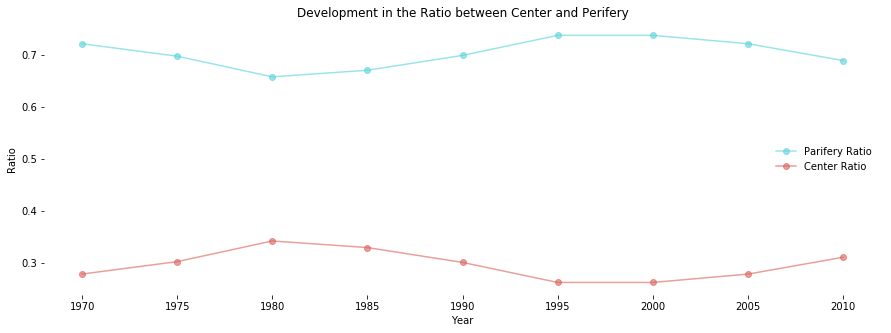

In [20]:
def center_ratio_plot(df=df):

    years = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]
    
    center_list = []
    center_ratio_list = []
    perifery_list = []
    
    for i in range(len(years)):
        
        size_of_center = df[(df['year'] == years[i]) & (df['center'] == 1)].shape[0]

        center_ratio = size_of_center / df[df['year'] == years[i]].shape[0]
        
        perifery_ratio = 1 - center_ratio

        center_list.append(size_of_center)
        center_ratio_list.append(center_ratio)
        perifery_list.append(perifery_ratio)
    
    # Ratio plot
    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)

    plt.figure(figsize= [15,5])

    label1 = 'Center Ratio'
    label2 = 'Parifery Ratio'
    
    x = years
    y1 = center_ratio_list
    y2 = perifery_list

    plt.plot(x, y2, '-o', alpha = 0.6, color = colors[1], label = label2)
    plt.plot(x,y1,'-o',alpha = 0.6, color = colors[0], label = label1)
    
    plt.xlabel('Year')
    plt.ylabel("Ratio")#right

    plt.title('Development in the Ratio between Center and Perifery')

    sns.despine(left = True, bottom = True)
    #plt.grid()
    plt.legend(frameon = False)   
    plt.show() 
        
center_ratio_plot()

Men er det for grovt? Er det interresant med de andre (ikke center) Cores?
Læs op på algoritmen of tag stilling..
kan du bruge transition fra Center til Perifiry som "Downgrading?"

# Linear interploation (Still under construction!) :

In [67]:
def get_full_df(df=df):   
    
    min_year = df['year'].min()
    max_year = df['year'].max()

    full_year_range = np.arange(min_year, max_year+1, 1)

    list_of_dfs = []

    for country in df['country'].unique():
        temp_df = pd.DataFrame(full_year_range, columns= ['year'])
        temp_df['country'] = country
        list_of_dfs.append(temp_df)

    df_full_year = pd.concat(list_of_dfs)    

    df_full = df_full_year.merge(df, on=['year','country'], how='outer')
    return(df_full)

In [68]:
df_full = get_full_df()

In [69]:
intpl_df = df_full.groupby('country').apply(lambda group: group.interpolate(method='linear'))

In [70]:
def interp_plot(df=df, intpl_df = intpl_df, country = 'USA', metric = 'indegree_norm'):
    
    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)
    plt.figure(figsize= [15,5])



    y = df[df['country'] == country][metric]
    x = df[df['country'] == country]['year']
    plt.plot(x ,y, 'o', ms = 15, label = 'original matric', color = colors[0], alpha = 1)


    y = intpl_df[intpl_df['country'] == country][metric]
    x = intpl_df[intpl_df['country'] == country]['year']
    plt.plot(x ,y, '-o', label = 'interpolated metric', color = colors[1], alpha = 1)

    plt.xlabel('Years')
    plt.ylabel('{}'.format(metric))
    plt.title('Linear Interpolation - {} Example'.format(country))


    sns.despine(left = True, bottom = True)
    plt.legend(frameon = False)   


    plt.show()

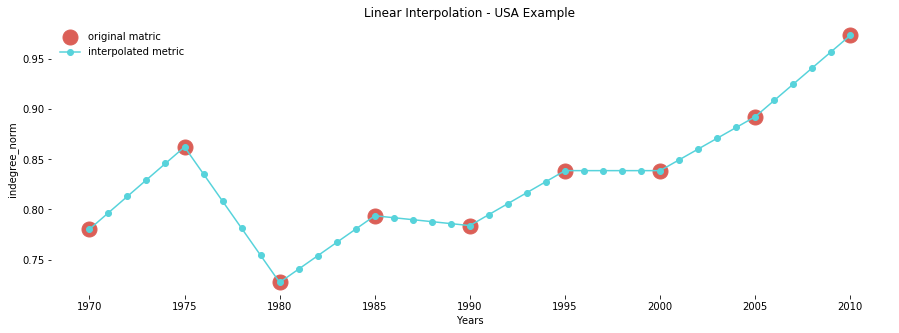

In [71]:
interp_plot()

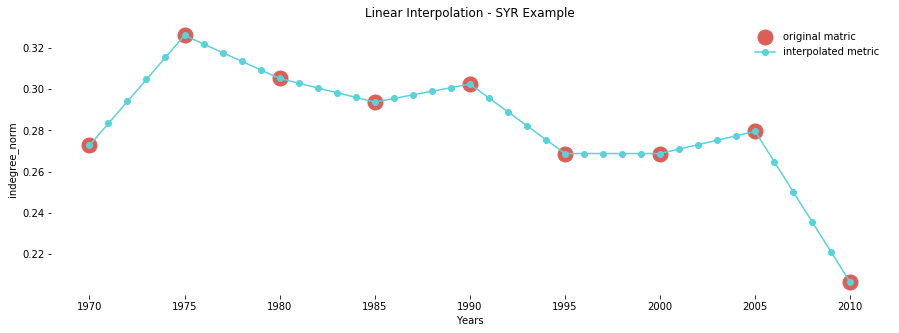

In [72]:
interp_plot(country = 'SYR')

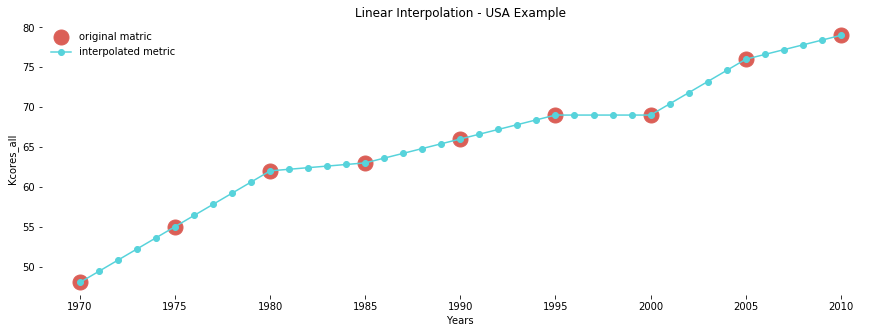

In [77]:
interp_plot(country = 'USA', metric='Kcores_all')

# Downgrading:
## Men det bør jo første være efter interpolationen? ja!

In [21]:
# men denne her ser vel også anderledes ud hvis du interpolerer?

df['center_lag'] = df.groupby(['country'])['center'].shift(1)
df['downgrading'] = 0
df.loc[(df['center'] == 0) & (df['center_lag'] == 1), 'downgrading'] = 1

In [22]:
df[df['downgrading'] == 1][['country','year']] # intraeguing..

,country,year
150,COL,1975
151,VEN,1975
158,CHL,1975
160,URU,1975
169,POR,1975
497,SEN,1985
514,DRC,1985
539,LIB,1985
610,COL,1990
615,PER,1990


# Degree Slope

In [23]:
df['indegree_norm_lag'] = df.groupby(['country'])['indegree_norm'].shift(1) # men norm eller abs?
df['slope_indegree'] = df['indegree_norm'] - df['indegree_norm_lag'] 

df['outdegree_norm_lag'] = df.groupby(['country'])['outdegree_norm'].shift(1) # men norm eller abs?
df['slope_outdegree'] = df['outdegree_norm'] - df['outdegree_norm_lag'] 

df['degree_norm_lag'] = df.groupby(['country'])['degree_norm'].shift(1) # men norm eller abs?
df['slope_degree'] = df['degree_norm'] - df['degree_norm_lag'] 

# Linear interploation (Still under construction!) :

In [24]:
def get_full_df(df=df):   
    
    min_year = df['year'].min()
    max_year = df['year'].max()

    full_year_range = np.arange(min_year, max_year+1, 1)

    list_of_dfs = []

    for country in df['country'].unique():
        temp_df = pd.DataFrame(full_year_range, columns= ['year'])
        temp_df['country'] = country
        list_of_dfs.append(temp_df)

    df_full_year = pd.concat(list_of_dfs)    

    df_full = df_full_year.merge(df, on=['year','country'], how='outer')
    return(df_full)


In [25]:
df_full = get_full_df()

In [26]:
intpl_df = df_full.groupby('country').apply(lambda group: group.interpolate(method='linear'))

In [27]:
def interp_plot(df=df, intpl_df = intpl_df, country = 'USA', metric = 'indegree_norm'):
    
    colors = sns.palettes.color_palette(palette = "hls", n_colors = 2)
    plt.figure(figsize= [15,5])



    y = df[df['country'] == country][metric]
    x = df[df['country'] == country]['year']
    plt.plot(x ,y, 'o', ms = 15, label = 'original matric', color = colors[0], alpha = 1)


    y = intpl_df[intpl_df['country'] == country][metric]
    x = intpl_df[intpl_df['country'] == country]['year']
    plt.plot(x ,y, '-o', label = 'interpolated metric', color = colors[1], alpha = 1)

    plt.xlabel('Years')
    plt.ylabel('{}'.format(metric))
    plt.title('Linear Interpolation - {} Example'.format(country))


    sns.despine(left = True, bottom = True)
    plt.legend(frameon = False)   


    plt.show()

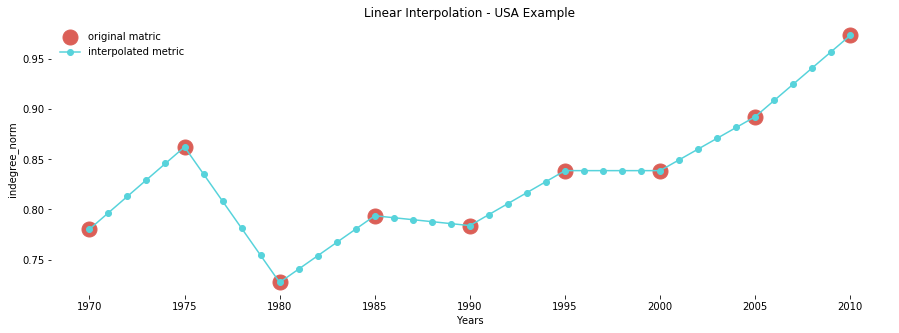

In [28]:
interp_plot()

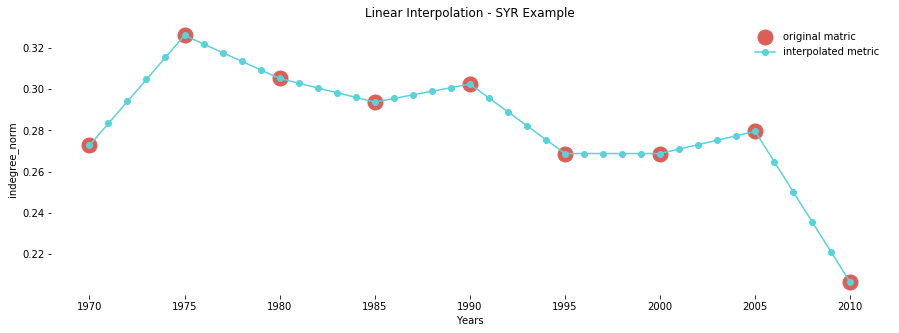

In [29]:
interp_plot(country = 'SYR')

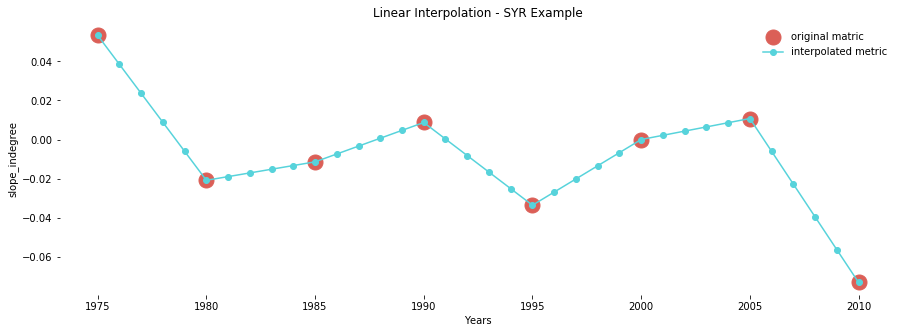

In [30]:
interp_plot(country = 'SYR', metric = 'slope_indegree')

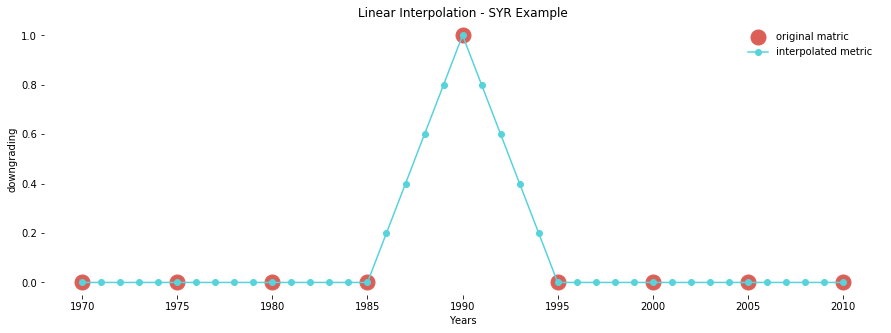

In [31]:
interp_plot(country = 'SYR', metric = 'downgrading')

In [32]:
intpl_df.to_csv('interpolated_df.csv')